In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import os
from PIL import Image
from torchvision.transforms import v2
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

#### Data Transforms

In [27]:
data_transforms = {
    'train': transforms.Compose([
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
        v2.Resize((256, 256))
    ]),
    'test': transforms.Compose([
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
        v2.Resize((256, 256))
    ]),
}

#### Read Data

In [28]:
data_dir = '../data/alzheimer_mri'
data_sets = ['train','test']
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in data_sets
}

dataloaders = {
    x: DataLoader(
        image_datasets[x], 
        batch_size=4,
        shuffle=True, 
        num_workers=4
    )
    for x in data_sets
}

dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in data_sets
}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Visualize Images

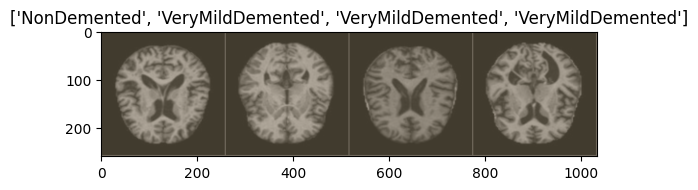

In [29]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [32]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                #if phase == 'train':
                #    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_val_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [37]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Set the size of each output sample to nn.Linear(num_ftrs, len(class_names))
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [35]:
model = train_model(model, criterion, optimizer,num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0122 Acc: 0.5119
test Loss: 1.0680 Acc: 0.4336

Epoch 1/24
----------
train Loss: 0.9668 Acc: 0.5385
test Loss: 0.9380 Acc: 0.5586

Epoch 2/24
----------
train Loss: 0.9524 Acc: 0.5355
test Loss: 0.9150 Acc: 0.5953

Epoch 3/24
----------
train Loss: 0.9183 Acc: 0.5650
test Loss: 0.8930 Acc: 0.5781

Epoch 4/24
----------
train Loss: 0.8788 Acc: 0.5824
test Loss: 0.8098 Acc: 0.6312

Epoch 5/24
----------
train Loss: 0.8062 Acc: 0.6348
test Loss: 0.7187 Acc: 0.6789

Epoch 6/24
----------
train Loss: 0.6235 Acc: 0.7379
test Loss: 0.4528 Acc: 0.8211

Epoch 7/24
----------
train Loss: 0.3796 Acc: 0.8537
test Loss: 0.2930 Acc: 0.8891

Epoch 8/24
----------
train Loss: 0.2202 Acc: 0.9213
test Loss: 0.2168 Acc: 0.9180

Epoch 9/24
----------
train Loss: 0.1504 Acc: 0.9432
test Loss: 0.2585 Acc: 0.9016

Epoch 10/24
----------
train Loss: 0.0971 Acc: 0.9637
test Loss: 0.1492 Acc: 0.9570

Epoch 11/24
----------
train Loss: 0.0691 Acc: 0.9750
test Loss: 0.1370 Acc

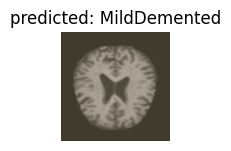

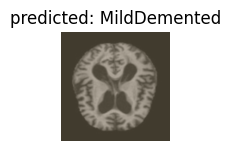

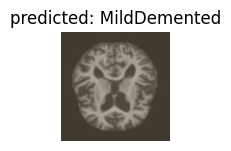

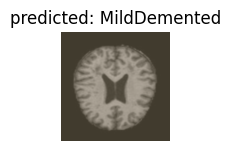

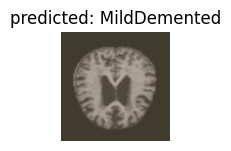

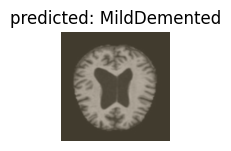

In [38]:
visualize_model(model)